## **Steps**
1. process image (grey, blur, threshold)
2. find card contour
3. process card (cut, resize, perspective transform)
4. cut rank and suit
5. compare rank and suit to templates

## **TODO**
1. wider card capture

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure

In [2]:
CARD_MAX_AREA = 5000000
CARD_MIN_AREA = 500000

In [3]:
def prepare_image(img):
    """Prepares the image and applies filters.
    Returns the processed image."""
    img_processed = cv2.GaussianBlur(img,(5,5),0)
    
    thresh, img_processed = cv2.threshold(img_processed,170,255,cv2.THRESH_BINARY)
    cv2.imwrite('./figures/prepared.jpg',img_processed)
    return img_processed

In [4]:
def find_cards(img):
    """Finds all card-sized contours in the processed image.
    Returns a list of card contours sorted
    from largest to smallest."""
    
    # Find contours and sort the indices by contour size
    contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    index_sort = sorted(range(len(contours)), key=lambda i : cv2.contourArea(contours[i]),reverse=True)
    
    # No contours found
    if len(contours) == 0:
        return None

    contours_sorted = []
    hierarchy_sorted = []

    for i in index_sort:
        contours_sorted.append(contours[i])
        hierarchy_sorted.append(hierarchy[0][i])


    # Find the card contours among all contours. In order for the contour
    # to be considered a card the following criteria must be met:
    #     1) The contour area must be between the predefined MIN and MAX card sizes
    #     2) The contour must have no parents
    #     3) The contour must have exactly 4 corners
    card_contours = []
    for i in range(len(contours_sorted)):
        size = cv2.contourArea(contours_sorted[i])
        epsilon = cv2.arcLength(contours_sorted[i],True) * 0.02
        corner_pts = cv2.approxPolyDP(contours_sorted[i], epsilon,True)
        if (size < CARD_MAX_AREA) and (size > CARD_MIN_AREA) and (hierarchy_sorted[i][3] == -1) and (len(corner_pts) == 4):
            card_contours.append(contours_sorted[i])

    return card_contours

In [5]:
def process_card(contour):
    """Finds the corners of the card, and moves them into an array.
    Checks if the card is tilted and moves the corners accordingly.
    Using cv2.getPerspectiveTransform gets the transformation matrix and
    using cv2.warpPerspective moves it into a blank image.
    Returns the corners array and the new image."""
    
    ## Isolate the card
    corners = []
    
    # Finding 4 corner points for each card
    corner_pts = []
    epsilon = cv2.arcLength(contour,True) * 0.02
    corner_pts = cv2.approxPolyDP(contour, epsilon,True)
    
    # Find card dimensions
    x,y,w,h = cv2.boundingRect(contour) # xy - coordinates of top left corner, wh - width heigth
    corners = corner_pts

    temp_rect = np.zeros((4,2), dtype = "float32")
    s = np.sum(corner_pts, axis = 2)
    tl = corner_pts[np.argmin(s)]
    br = corner_pts[np.argmax(s)]
    diff = np.diff(corner_pts, axis = -1)
    
    tr = corner_pts[np.argmin(diff)]
    bl = corner_pts[np.argmax(diff)]

    # Capturing wider area around the card to prevent cutting parts of the card
    tl -= 20
    tr[0][0] += 20
    tr[0][1] -= 20

    bl[0][0] -= 20
    bl[0][1] += 20
    br += 20

    # Moving correct corners into an array
    if w <= 0.9*h: # vertical
        temp_rect[0] = tl
        temp_rect[1] = tr
        temp_rect[2] = br
        temp_rect[3] = bl
        
    if w >= 1.1*h: # horizontal
        temp_rect[0] = bl
        temp_rect[1] = tl
        temp_rect[2] = tr
        temp_rect[3] = br

    if w > 0.9*h and w < 1.1*h: # tilted
        if corner_pts[1][0][1] <= corner_pts[3][0][1]: # tilted to the left
            temp_rect[0] = corner_pts[1][0] # Top left
            temp_rect[1] = corner_pts[0][0] # Top right
            temp_rect[2] = corner_pts[3][0] # Bottom right
            temp_rect[3] = corner_pts[2][0] # Bottom left
        if corner_pts[1][0][1] > corner_pts[3][0][1]: # tilted to the right
            temp_rect[0] = corner_pts[0][0] # Top left
            temp_rect[1] = corner_pts[3][0] # Top right
            temp_rect[2] = corner_pts[2][0] # Bottom right
            temp_rect[3] = corner_pts[1][0] # Bottom left
            
    maxWidth = 400
    maxHeight = 600
    dst = np.array([[0,0], # Top left
            [maxWidth-1,0], # Top right
            [maxWidth-1,maxHeight-1], # Bottom right
            [0, maxHeight-1]], np.float32) # Bottom left
    
    M = cv2.getPerspectiveTransform(temp_rect,dst)
    warp = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
    thresh, img_processed = cv2.threshold(warp,150,255,cv2.THRESH_BINARY)
    
    return img_processed, corners

In [6]:
def crop_rank(card):
    """Crops the area around the rank, applies filters and resizes 
    the output in order to prepare for isolating the rank."""
    
    img_cropped = card[0:110, 0:75]     # crop_img = img[y:y+h, x:x+w]
    img_cropped = cv2.GaussianBlur(img_cropped,(11,11),0)
    img_cropped = cv2.resize(img_cropped, (0,0), fx=6, fy=6, interpolation=cv2.INTER_LINEAR)
    thresh, img_cropped = cv2.threshold(img_cropped,150,255,cv2.THRESH_BINARY)
    img_cropped = cv2.erode(img_cropped, np.ones((3, 3)))
    return img_cropped

In [7]:
def crop_suit(card):
    """Crops the area around the suit, applies filters and resizes 
    the output in order to prepare for isolating the suit."""
    
    img_cropped = card[75:175, 0:70]     # crop_img = img[y:y+h, x:x+w]
    img_cropped = cv2.GaussianBlur(img_cropped,(11,11),0)
    img_cropped = cv2.resize(img_cropped, (0,0), fx=6, fy=6, interpolation=cv2.INTER_LINEAR)
    thresh, img_cropped = cv2.threshold(img_cropped,150,255,cv2.THRESH_BINARY)
    img_cropped = cv2.erode(img_cropped, np.ones((3, 3)))
    return img_cropped

In [8]:
def isolate_rank(rank_area):
    """Isolates the rank from the cropped rank area by finding biggest contour 
    while ignoring the contours which land on the border.
    Returns an isolated thresholded rank image resized to a specific size in order
    to prepare for template comparison"""
    
    contours, hierarchy = cv2.findContours(rank_area,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    max_size = 0
    max_index = 0
    height, width = rank_area.shape[:2]
    
    for i in range(len(contours)):
        size = cv2.contourArea(contours[i])
        on_border = False
        for point in contours[i]:
            if point[0][0] == 0 or point[0][0] == width - 1 or point[0][1] == 0 or point[0][1] == height - 1:
                on_border = True
                break
        if size > max_size and on_border == False:
            max_size = size
            max_index = i

    blank_image = np.zeros((height,width,3), np.uint8)
    image_contour = cv2.drawContours(blank_image, contours[max_index], -1, (255, 255, 255), 2)
    
    x,y,w,h = cv2.boundingRect(contours[max_index])
    image_contour = image_contour[y-10:y+h+10, x-10:x+w+10]# crop_img = img[y:y+h, x:x+w]
    rank = rank_area[y-10:y+h+10, x-10:x+w+10]# crop_img = img[y:y+h, x:x+w]
    rank = cv2.resize(rank, (260,400))
    return rank

In [9]:
def isolate_suit(suit_area):
    """Isolates the suit from the cropped suit area by finding biggest contour 
    while ignoring the contours which land on the border.
    Returns an isolated thresholded suit image resized to a specific size in order
    to prepare for template comparison"""
    
    contours,hierarchy = cv2.findContours(suit_area,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    height, width = suit_area.shape[:2]
    max_size = 0
    max_index = 0
    for i in range(len(contours)):
        size = cv2.contourArea(contours[i])
        on_border = False
        for point in contours[i]:
            if point[0][0] == 0 or point[0][0] == width - 1 or point[0][1] == 0 or point[0][1] == height - 1:
                on_border = True
                break
        if size > max_size and on_border == False:
            max_size = size
            max_index = i

    blank_image = np.zeros((height,width,3), np.uint8)
    image_contour = cv2.drawContours(blank_image, contours[max_index], -1, (255, 255, 255), 2)
    
    x,y,w,h = cv2.boundingRect(contours[max_index])
    image_contour = image_contour[y-10:y+h+10, x-10:x+w+10]# crop_img = img[y:y+h, x:x+w]
    suit = suit_area[y-10:y+h+10, x-10:x+w+10]# crop_img = img[y:y+h, x:x+w]
    suit = cv2.resize(suit, (260,400))
    return suit

In [10]:
def compare_rank(rank, names):
    """Reads the rank templates. Then process the cut fragment
    in order to get the rank to the most readable state.
    Then performs an absolute pixel comparison between them.
    Returns the list of absolute pixel differences between the isolated
    rank and templates."""
    differences = []
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16,12))
    row = -1
    for i,name in enumerate(names):
        img = cv2.imread(f'./scan_templates/{name}.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.GaussianBlur(img,(11,11),0)
        retval, template = cv2.threshold(img,180,255,cv2.THRESH_BINARY)
        template = cv2.erode(template, np.ones((11,11)))
        template = cv2.dilate(template, np.ones((11,11)))
        template = cv2.resize(template, (260,400))
        difference = cv2.absdiff(rank, template)
        ax[row][i%4].imshow(difference, cmap='gray')
        differences.append(difference)
        if i%4 == 0:
            row += 1
    plt.savefig('./figures/rank_comparison.jpg')
    plt.close()
    return differences

In [11]:
def compare_suit(suit, names):
    """Reads the suit templates. Then process the cut fragment
    in order to get the suit to the most readable state.
    Then performs an absolute pixel comparison between them.
    Returns the list of absolute pixel differences between the isolated
    suit and templates."""
    differences = []
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
    for i,name in enumerate(names):
        img = cv2.imread(f'./scan_templates/{name}.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.GaussianBlur(img,(11,11),0)
        retval, template = cv2.threshold(img,180,255,cv2.THRESH_BINARY)
        template = cv2.erode(template, np.ones((11,11)))
        template = cv2.dilate(template, np.ones((11,11)))
        template = cv2.resize(template, (260,400))
        difference = cv2.absdiff(suit, template)
        ax[i].imshow(difference, cmap='gray')
        differences.append(difference)
    plt.savefig('./figures/suit_comparison.jpg')
    plt.close()
    return differences

In [12]:
"""Main function. Loads the input image, preprocesses it and finds the cards.
Then, each card is processed in order to isolate its rank and suit.
Once isolated, they are compared with the prepared templates using the absolute
pixel difference. Templates with the smallest absolute pixel difference values
are chosen as the best matches."""

if __name__ == '__main__':
    img = cv2.imread(f"./new_images/c8.jpg", cv2.IMREAD_GRAYSCALE) # not working for QPT
    image_original = cv2.imread(f"./new_images/c8.jpg") 
    img_processed = prepare_image(img)
    card_contours = find_cards(img_processed)
    rank_names = ['2','3', '4', '5', '6', '7', '8', '9', 'A', 'J', 'K', 'Q']
    suit_names = ['hearts', 'clubs', 'diamonds', 'spades']

    # Process all found card contours
    for i, card_contour in enumerate(card_contours):
        warp, corners = process_card(card_contour)
        warp2 = warp.copy()
        cv2.imwrite(f'./figures/warped.jpg', warp)
        rank = crop_rank(warp)
        cv2.imwrite(f'./figures/rank_cropped.jpg', rank)
        rank = isolate_rank(rank)
        cv2.imwrite(f'./figures/rank_isolated.jpg', rank)
        rank_differences = compare_rank(rank,rank_names)
        
        # Finds the best matching rank
        rank_scores = [np.count_nonzero(difference) for difference in rank_differences]
        found_rank = rank_names[rank_scores.index(min(rank_scores))]

        suit = crop_suit(warp2)
        cv2.imwrite(f'./figures/suit_cropped.jpg', suit)
        suit = isolate_suit(suit)
        cv2.imwrite(f'./figures/suit_isolated.jpg', suit)
        suit_differences = compare_suit(suit,suit_names)
        
        # Finds the best matching suit
        suit_scores = [np.count_nonzero(difference) for difference in suit_differences]
        found_suit = suit_names[suit_scores.index(min(suit_scores))]

        # Preparing the final output image
        w,h = image_original.shape[:2]
        text = found_rank.upper() + ' OF ' + found_suit.upper()
        text_suits = [(255,40,40), (40,255,40), (40,40,255), (255,255,40), (255,40,255), (40,255,255), (80,150,40), (170,60,80), (130,10,80)]
        pts = np.array([corners[0][0],corners[1][0],corners[2][0],corners[3][0]], np.int32)
        pts = pts.reshape((-1, 1, 2))
        
        # Draws polygons around the cards and text with result next to them
        image_original = cv2.polylines(image_original, [pts], 
                              True, text_suits[i], 20)
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_DUPLEX, w * 0.0006, int(w * 0.0015))[0]
        offset_x = 10
        offset_y = 10
        print(corners[0][0][0] + text_size[0] + offset_x, h)
        
        if corners[0][0][0] + text_size[0] + offset_x > h:
            offset_x = corners[0][0][0] + text_size[0] + offset_x - h
            print('y')
        print()
        
        # Draws a rectangle in the background of the text so it is visible
        cv2.rectangle(image_original, (corners[0][0][0] - offset_x, corners[0][0][1] - int(w * 0.03)), (corners[0][0][0] + text_size[0] + 10, corners[0][0][1] + text_size[1] + 10), (58,48,43), -1)
        cv2.putText(image_original, text, (corners[0][0][0] - offset_x, corners[0][0][1] - 5), cv2.FONT_HERSHEY_DUPLEX, w * 0.0006, text_suits[i], int(w * 0.0015), 2)
        print(text)
        
    cv2.imwrite(f'./figures/output.jpg', image_original)

3244 3024
y

7 OF CLUBS
1521 3024

J OF DIAMONDS
2324 3024

2 OF SPADES
3260 3024
y

K OF SPADES
1492 3024

8 OF SPADES
2348 3024

5 OF HEARTS
2475 3024

6 OF HEARTS
1523 3024

Q OF CLUBS
2386 3024

4 OF HEARTS


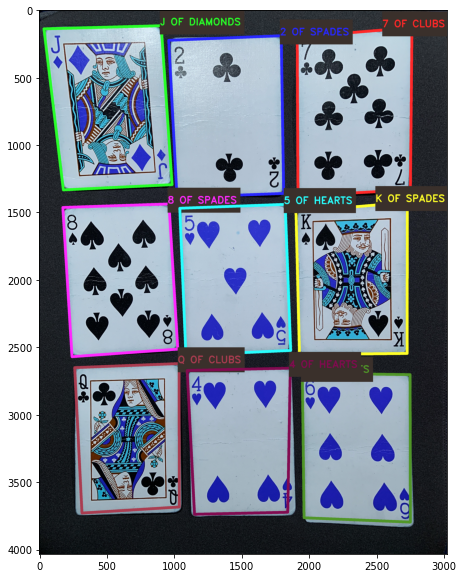

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(image_original, cmap='gray')